In [2]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [4]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [5]:
# Read and output the top 5 rows
ins_data = pd.read_csv("insurance.csv")
ins_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


156


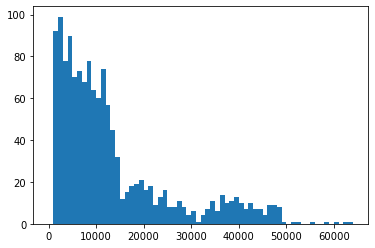

In [6]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<5000: return 0 # First"Peak"
    if x<16000: return 1 # Second Peak
    if x<31000: return 2 # Thrid Peak
    return 3
print(len(ins_data[ins_data["charges"]>31000]))
ins_data["charges"]=ins_data["charges"].map(transform)

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [7]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


In [8]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop("charges", axis = 1), ins_data["charges"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

In [9]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

([<pandas.io.formats.style.Styler at 0x27c08d57390>],
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 1095  18.0  31.350000       4.0         1.0        1.0               1.0   
 1130  39.0  23.870001       5.0         1.0        1.0               0.0   
 1294  58.0  25.174999       0.0         0.0        1.0               1.0   
 860   37.0  47.599998       2.0         1.0        0.0               0.0   
 1126  55.0  29.900000       0.0         0.0        1.0               0.0   
 
       region_northw

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [10]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8790,0.9368,0.8444,0.8803,0.8739,0.8171,0.8207,0.1820
gbc,Gradient Boosting Classifier,0.8728,0.9344,0.8361,0.8750,0.8672,0.8072,0.8110,0.1920
lr,Logistic Regression,0.8641,0.9184,0.8133,0.8678,0.8563,0.7924,0.7979,0.9280
lightgbm,Light Gradient Boosting Machine,0.8641,0.9339,0.8289,0.8659,0.8587,0.7950,0.7982,0.1480
ridge,Ridge Classifier,0.8504,0.0000,0.7909,0.8600,0.8322,0.7723,0.7804,0.0210
et,Extra Trees Classifier,0.8416,0.9291,0.7998,0.8410,0.8379,0.7617,0.7644,0.1840
lda,Linear Discriminant Analysis,0.8392,0.9222,0.7714,0.8444,0.8131,0.7560,0.7664,0.0170
dt,Decision Tree Classifier,0.8129,0.8649,0.8000,0.8253,0.8141,0.7230,0.7262,0.0240
ada,Ada Boost Classifier,0.7619,0.8576,0.6504,0.6943,0.7176,0.6379,0.6526,0.0540
nb,Naive Bayes,0.7443,0.9201,0.7422,0.7894,0.7368,0.6294,0.6525,0.0230


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1075, verbose=0,
                       warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [11]:
rf = create_model("rf") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9259,0.9805,0.9099,0.9252,0.9228,0.8885,0.8899
1,0.8519,0.9315,0.8386,0.8517,0.8504,0.7796,0.7803
2,0.8625,0.9224,0.8172,0.8536,0.8511,0.7902,0.7941
3,0.8875,0.9440,0.8519,0.8929,0.8857,0.8272,0.8312
4,0.8750,0.9342,0.8417,0.8781,0.8724,0.8137,0.8169
5,0.9000,0.9556,0.8585,0.9113,0.8978,0.8454,0.8517
6,0.8500,0.8721,0.8001,0.8409,0.8400,0.7728,0.7761
7,0.9125,0.9730,0.8900,0.9140,0.9123,0.8696,0.8702
8,0.8750,0.9433,0.8348,0.8853,0.8737,0.8132,0.8178
9,0.8500,0.9114,0.8017,0.8500,0.8328,0.7710,0.7787


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

# **Generating synthetic data** 
# **NAIVE GENERATING**
# **CTGAN**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [12]:
def MAXINT(a,b): return (abs(a-b)+(a+b))//2

def MAX(a,b): return (abs(a-b)+(a+b))/2

def MININT(a,b): return (-abs(a-b)+(a+b))//2

def MIN(a,b): return (-abs(a-b)+(a+b))/2

def over_18(data): return MAXINT(data["age"],18)

age_constraint = cons.ColumnFormula(column = 'age',
                                    formula = over_18,
                                    handling_strategy = 'reject_sampling')

def children_range(data): return MININT(MAXINT(data["children"],0),5)

children_constraint = cons.ColumnFormula(column = 'children',
                                         formula = children_range,
                                         handling_strategy = 'reject_sampling')

min_bmi = min(ins_data["bmi"])
max_bmi = max(ins_data["bmi"])
print(min_bmi,max_bmi)

def bmi_range(data): return MIN(MAX(data["bmi"],min_bmi),max_bmi)

bmi_constraint = cons.ColumnFormula(column = 'bmi',
                                    formula = bmi_range,
                                    handling_strategy = 'reject_sampling')

min_charges= min(ins_data["charges"])
max_charges = max(ins_data["charges"])
print(min_charges,max_charges)

def charges_range(data): return MIN(MAX(data["charges"],min_charges*0.8),max_charges*1.25)

charges_constraint = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range,
                                    handling_strategy = 'reject_sampling')

def charges_range_truncated(data): return MIN(MAX(data["charges"],12000),max_charges*1.25)

charges_constraint_2 = cons.ColumnFormula(column = 'charges',
                                    formula = charges_range_truncated,
                                    handling_strategy = 'reject_sampling')

15.96 53.13
0 3


In [13]:
import time
best_score = 0 # Keep track of best score
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left
ST=time.time()
## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)

    # Get the hyperparameters for this loop
    #proposal = tuner.propose(1)
  
    # Create the CopulaGAN -> GAussianCopu;a
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    
    # Fit the CTGAN
    model.fit(real)
    metadata = model.get_metadata()
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 600)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        #best_params = proposal
        best_score = score
  


## TRAINING LOOP END ##
ED=time.time()
print((ED-ST)/60,"minutes")

1
0.5891410929724538
2
0.48158768497404353
3
0.506542464178791
4
0.5420949734173611
5
0.47036591054408877
6
0.4884557439585662
7
0.5922876897497953
8
0.6140528195193619
9
0.48625986307490837
10
0.547980356705342
11
0.5838001440720292
12
0.5275151970702004
13
0.4520621588155527
14
0.4882196402305126
15
0.5228671146066648
16
0.5852267473328516
17
0.6077055981635021
18
0.5358922503071034
19
0.5765645411803739
20
0.568747667645034
21
0.5398129934096891
22
0.494428557686275
23
0.6188450114872106
24
0.600472375625511
25
0.5617174101731017
26
0.5712116793607004
27
0.5518828365598382
28
0.5663670937740919
29
0.5575664516201633
30
0.48559210348660187
20.673219617207845 minutes


In [14]:
metadata

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

In [15]:
bmi=synth_data["bmi"]

In [16]:
bmi.describe()

count    600.000000
mean      38.988105
std        6.843401
min       17.809471
25%       34.374475
50%       38.863432
75%       44.119144
max       53.109870
Name: bmi, dtype: float64

In [17]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.699678,0.067227,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.835990,0.835990,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.377869,0.377869,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1114.261443,0.000000,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.932434,0.932434,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.894417,0.894417,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.917778,0.917778,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.608706,0.608706,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.979045,0.979045,0.0,1.0,MAXIMIZE


In [18]:
score['normalized_score'].mean()

0.6237184804714013

In [19]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = True)
score

0.6234127441611431

In [20]:
print(max(scores))
print(min(scores))

0.6188450114872106
0.4520621588155527


In [21]:
model.save('best_copula.pkl')

In [22]:
synth_data.to_csv("ins_synth_data_classifier_CTGANImb.csv", index = False)

So after 75 loops the overall score is 0.81 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [23]:
# Load synth data in
synth_data = pd.read_csv("ins_synth_data_classifier_CTGANImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data])

In [24]:
synth_data

,age,sex,bmi,children,smoker,region,charges
0,58,female,42.952625,0,yes,southeast,1
1,29,male,41.783000,0,no,northeast,0
2,31,female,39.215343,0,no,southwest,0
3,58,male,35.963096,0,yes,southeast,0
4,37,female,33.308222,5,no,northwest,1
...,...,...,...,...,...,...,...
595,30,female,41.744318,0,no,northeast,1
596,27,male,29.278372,0,no,southwest,1
597,34,female,44.528648,1,no,southeast,0
598,52,female,46.553473,0,no,southwest,1


In [25]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1402, 7)
Testing size (real: (536, 7)


In [26]:
ord_feats = {"children" : list("012345")}

The ratio of the synthetic data of charge >14000 is 0.0000


(array([299., 200.,  85.,  16.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

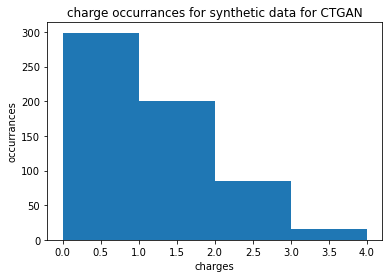

In [27]:
from matplotlib import pyplot as plt
#num_bins = 20
#group = [1000*i for i in range(13,65)]
#plt.hist(synth_data["charges"], group)
total01=len(synth_data["charges"])
ans01=[]
for i in range(0,4):
    num=len(synth_data["charges"][synth_data["charges"]==i])
    ans01.append(num/total01)
ans01=np.array(ans01)
print("The ratio of the synthetic data of charge >14000 is %.4f"%sum(ans01[14:]))
plt.title("charge occurrances for synthetic data for CTGAN")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(synth_data["charges"],bins=[i for i in range (5)])

The ratio of the original data of charge >14000 is 0.0000


(array([359., 633., 190., 156.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

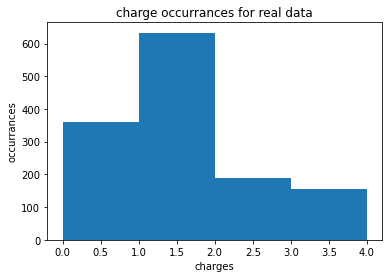

In [28]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total02=len(ins_data["charges"])
ans02 = []
for i in range(4):
    num=len(ins_data["charges"][ins_data["charges"]==i])
    ans02.append(num/total02)
ans02=np.array(ans02)
print("The ratio of the original data of charge >14000 is %.4f"%sum(ans02[14:]))
plt.title("charge occurrances for real data")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(ins_data["charges"],bins=[i for i in range (5)])

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [29]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = target, 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

([<pandas.io.formats.style.Styler at 0x27c0c983d30>],
        age        bmi  children  sex_female  smoker_no  region_northeast  \
 25    59.0  27.719999       3.0         1.0        1.0               0.0   
 336   60.0  25.740000       0.0         0.0        1.0               0.0   
 47    28.0  34.770000       0.0         1.0        1.0               0.0   
 106   19.0  28.400000       1.0         1.0        1.0               0.0   
 1269  45.0  27.500000       3.0         0.0        1.0               0.0   
 ...    ...        ...       ...         ...        ...               ...   
 595   30.0  41.744320       0.0         1.0        1.0               1.0   
 596   27.0  29.278372       0.0         0.0        1.0               0.0   
 597   34.0  44.528648       1.0         1.0        1.0               0.0   
 598   52.0  46.553471       0.0         1.0        1.0               0.0   
 599   34.0  35.893013       2.0         1.0        1.0               0.0   
 
       region_northw

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [30]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6224,0.7550,0.5636,0.6176,0.6082,0.4231,0.4292,0.2130
lightgbm,Light Gradient Boosting Machine,0.6039,0.7474,0.5128,0.5988,0.5908,0.3940,0.3996,0.1160
rf,Random Forest Classifier,0.6003,0.7539,0.5318,0.6020,0.5895,0.3922,0.3974,0.1540
lr,Logistic Regression,0.5803,0.7274,0.4669,0.5720,0.5661,0.3602,0.3650,0.7240
et,Extra Trees Classifier,0.5739,0.7310,0.5017,0.5736,0.5641,0.3542,0.3585,0.1460
nb,Naive Bayes,0.5717,0.7288,0.5208,0.5768,0.5594,0.3700,0.3774,0.0150
lda,Linear Discriminant Analysis,0.5717,0.7282,0.5056,0.5807,0.5661,0.3737,0.3786,0.0160
ridge,Ridge Classifier,0.5668,0.0000,0.4028,0.5299,0.5309,0.3121,0.3222,0.0130
dt,Decision Tree Classifier,0.5461,0.6619,0.4831,0.5558,0.5441,0.3220,0.3239,0.0130
qda,Quadratic Discriminant Analysis,0.5304,0.7014,0.4772,0.5283,0.5131,0.3108,0.3206,0.0190


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=750, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

In [31]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8582,0.9443,0.7916,0.8636,0.8555,0.7837,0.7860
1,0.7872,0.9109,0.7088,0.7930,0.7797,0.6727,0.6774
2,0.9000,0.9463,0.8341,0.9081,0.8973,0.8467,0.8501
3,0.8357,0.9095,0.7885,0.8344,0.8306,0.7502,0.7528
4,0.6714,0.8297,0.6293,0.6838,0.6645,0.5045,0.5148
5,0.5929,0.7965,0.5874,0.6014,0.5622,0.3735,0.4018
6,0.4786,0.6569,0.3703,0.4497,0.4421,0.1794,0.1855
7,0.4071,0.5742,0.3928,0.3916,0.3844,0.0934,0.0957
8,0.3643,0.5316,0.3126,0.3323,0.3454,0.0424,0.0430
9,0.3286,0.4501,0.2201,0.3179,0.3198,-0.0152,-0.0154


# **SECOND TRIAL**, NORMALIZED, CTGAN

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [32]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint])
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 5000)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5792328872671137
2
0.5873268184406185
3
0.6079707022427736
4
0.4905169461020827
5
0.5125543093102318
6
0.5445614335303762
7
0.46761512942134786
8
0.5515962570804042
9
0.5523480829411771
10
0.5287135302874133
11
0.4907506634503121
12
0.5232659643235292
13
0.5959775790446048
14
0.4963825903499366
15
0.5787569866159795
16
0.5304964901435695
17
0.4904551813245137
18
0.5812988986954155
19
0.5167920597151479
20
0.5406411635047096
21
0.6117362151353549
22
0.5192410305183858
23
0.53327250081972
24
0.5381990007019635
25
0.5315160216127732
26
0.5285686551174873
27
0.5034532104351306
28
0.587426528522753
29
0.5532808722021479
30
0.6018829055279505
time used: 20.454 mins


In [33]:
best_data

,age,sex,bmi,children,smoker,region,charges
0,22,male,25.744452,1,no,northwest,1
3,27,female,30.009945,1,no,southeast,3
10,27,male,24.810451,1,no,southeast,0
14,52,male,19.070730,0,no,southwest,1
15,49,male,20.431605,3,no,southwest,1
...,...,...,...,...,...,...,...
83,57,male,19.346933,1,no,southeast,0
87,25,female,30.720547,1,no,southeast,0
92,19,male,16.105866,3,no,northwest,1
95,57,female,25.586742,1,no,southeast,1


In [34]:
best_distributions

Table(name=None, field_names=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])

In [35]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

,metric,name,raw_score,normalized_score,min_value,max_value,goal
0,BNLogLikelihood,BayesianNetwork Log Likelihood,-2.690110,6.787350e-02,-inf,0.0,MAXIMIZE
1,LogisticDetection,LogisticRegression Detection,0.694400,6.944000e-01,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,0.372814,3.728136e-01,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-636.820386,2.706577e-277,-inf,inf,MAXIMIZE
12,CSTest,Chi-Squared,0.944998,9.449985e-01,0.0,1.0,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.850512,8.505117e-01,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.898495,8.984953e-01,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.655691,6.556913e-01,0.0,1.0,MAXIMIZE
28,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.985227,9.852268e-01,0.0,1.0,MAXIMIZE


In [36]:
synth=[]
for i in range (4):
    orig_size=len(train[train["charges"]==i])
    synth_part=best_data[best_data["charges"]==i]
    generate=synth_part.sample(n=min(max(0,350-orig_size),len(synth_part)))
    print(len(generate))
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

139
0
228
261


,age,sex,bmi,children,smoker,region,charges
3797,18,male,35.563653,0,yes,southeast,0
10148,24,female,26.566755,0,no,northwest,3
1807,42,female,33.209366,1,no,northwest,0
188,26,female,37.458124,0,no,southeast,3
3907,54,male,23.955476,1,no,northwest,3
...,...,...,...,...,...,...,...
2680,24,female,20.888019,0,yes,southwest,3
3077,27,female,36.336724,0,no,southeast,0
984,35,male,33.763344,0,yes,northwest,0
4148,41,male,19.122491,0,no,southwest,0


In [37]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

0.5246636612483022

In [38]:
print('Best score obtained: ', best_score)

Best score obtained:  0.6117362151353549


In [39]:
print(max(scores))
print(min(scores))

0.6117362151353549
0.46761512942134786


In [40]:
model.save('best_copula.pkl')

In [41]:
synth.to_csv("ins_synth_norm_CTGANImb.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [42]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_norm_CTGANImb.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [43]:
mixed

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720000,3,no,southeast,1
336,60,male,25.740000,0,no,southeast,1
47,28,female,34.770000,0,no,northwest,0
106,19,female,28.400000,1,no,southwest,0
1269,45,male,27.500000,3,no,southwest,1
...,...,...,...,...,...,...,...
623,36,female,39.928198,1,yes,southwest,3
624,21,male,20.760925,1,yes,northeast,3
625,32,female,32.117123,1,yes,northeast,3
626,67,male,30.617989,0,no,southeast,3


In [44]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

Training size (real): (802, 7)
Training size (fake + real): (1430, 7)
Testing size (real: (536, 7)


Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [45]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

([<pandas.io.formats.style.Styler at 0x27c13f84780>],
        age        bmi  children  sex_female  smoker_yes  region_northeast  \
 25    59.0  27.719999       3.0         1.0         0.0               0.0   
 336   60.0  25.740000       0.0         0.0         0.0               0.0   
 47    28.0  34.770000       0.0         1.0         0.0               0.0   
 106   19.0  28.400000       1.0         1.0         0.0               0.0   
 1269  45.0  27.500000       3.0         0.0         0.0               0.0   
 ...    ...        ...       ...         ...         ...               ...   
 623   36.0  39.928200       1.0         1.0         1.0               0.0   
 624   21.0  20.760925       1.0         0.0         1.0               1.0   
 625   32.0  32.117123       1.0         1.0         1.0               1.0   
 626   67.0  30.617989       0.0         0.0         0.0               0.0   
 627   46.0  25.942480       0.0         1.0         0.0               0.0   
 
       r

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [46]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5538,0.7709,0.5477,0.5346,0.5273,0.4032,0.4116,0.1660
lr,Logistic Regression,0.5510,0.7478,0.5445,0.5251,0.5056,0.3993,0.4164,0.6900
lda,Linear Discriminant Analysis,0.5476,0.7446,0.5407,0.5198,0.4911,0.3946,0.4159,0.0140
ridge,Ridge Classifier,0.5434,0.0000,0.5355,0.4848,0.4673,0.3884,0.4160,0.0130
nb,Naive Bayes,0.5413,0.7435,0.5328,0.5281,0.4838,0.3850,0.4067,0.0150
lightgbm,Light Gradient Boosting Machine,0.5280,0.7596,0.5232,0.5172,0.5163,0.3695,0.3725,0.0820
rf,Random Forest Classifier,0.5259,0.7540,0.5202,0.5103,0.5088,0.3664,0.3709,0.1480
ada,Ada Boost Classifier,0.5203,0.7248,0.5134,0.4872,0.4805,0.3582,0.3708,0.0400
qda,Quadratic Discriminant Analysis,0.5007,0.7176,0.4938,0.4829,0.4714,0.3319,0.3417,0.0140
et,Extra Trees Classifier,0.4881,0.7276,0.4822,0.4726,0.4737,0.3161,0.3191,0.1330


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8486, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

A gradient boosting classifier was decided upon.

# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

# **SECOND TRIAL**, CTGAN, NORMALIZED, CF

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [51]:
train

,age,sex,bmi,children,smoker,region,charges
25,59,female,27.720,3,no,southeast,1
336,60,male,25.740,0,no,southeast,1
47,28,female,34.770,0,no,northwest,0
106,19,female,28.400,1,no,southwest,0
1269,45,male,27.500,3,no,southwest,1
...,...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast,0
1130,39,female,23.870,5,no,southeast,1
1294,58,male,25.175,0,no,northeast,1
860,37,female,47.600,2,yes,southwest,3


In [ ]:
best_score = 0 # Keep track of best score
# best_params=None
best_data = None
tracker = 0 # Keep track of how many loops have completed
flag = True
scores=[]

real = train # Filter to only those employees that left

import time
ST=time.time()

## TRAINING LOOP START ##
for _ in range(30): # only 1 and do the test

    # Increment the tracker
    tracker += 1
  
    # Every 5 loops output the tracker -> 1 loop
    print(tracker)



    # Record the hyperparameters and score      
    # proposal = tuner.propose(1)
  
    # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
    #model = GaussianCopula(constraints = [age_constraint, children_constraint, bmi_constraint, charges_constraint])
    model = CTGAN(constraints = [age_constraint, children_constraint, bmi_constraint],
                 field_transformers = {k:"categorical_fuzzy" for k in ["sex", "smoker", "region"]})
    
    # Fit the CopulaGAN
    model.fit(real)
    # Create 600 rows of data
    synth_data = model.sample(num_rows = 1500)
  
    # Evaluate the synthetic data against the real data
    score = evaluate(synthetic_data = synth_data, real_data = real)
    scores.append(score)

    print(score)
    # If the new hyperparameters beat the best ones, store them along with the score
    if score > best_score or flag:
        flag = False
        best_data = synth_data
        best_distributions = model.get_metadata()
        # best_params = proposal
        best_score = score
  
    # Record the hyperparameters and score      
    # tuner.record(proposal, score)


## TRAINING LOOP END ##
ED=time.time()
print("time used: %.3f mins"%((ED-ST)/60))

1
0.5166155867221017
2
0.48477919496656985
3


In [ ]:
best_data

In [ ]:
best_distributions

In [ ]:
best=best_data
best_data=best_data[~best_data.index.duplicated()]
num_bins = 20
plt.hist(best_data["charges"], [2000*i for i in range (33)])

In [ ]:
score = evaluate(synthetic_data = best_data, real_data = real, aggregate = False)
score

In [ ]:
synth=[]
for i in range (6,32):
    orig_size=len(train[train["charges"]<(i+1)*2000][train["charges"]>(i)*2000])
    synth_part=best_data[best_data["charges"]<(i+1)*2000][best_data["charges"]>(i)*2000]
    generate=synth_part[:100-orig_size]
    synth.append(generate)
synth=pd.concat(synth)
synth.sample(frac=1)

In [ ]:
score = evaluate(synthetic_data = synth, real_data = train, aggregate = True)
score

In [ ]:
print('Best score obtained: ', best_score)

In [ ]:
print(max(scores))
print(min(scores))

In [ ]:
model.save('best_copula.pkl')

In [ ]:
synth.to_csv("ins_synth_dat_univariate.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [ ]:
# Load synth data in
synth_data2 = pd.read_csv("ins_synth_dat_univariate.csv")

# Add the 600 synthetic rows of data to training data + remove dataset column
mixed = pd.concat([train, synth_data2])

In [ ]:
mixed

In [ ]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", mixed.shape)
print("Testing size (real:", test.shape)

In [ ]:
#plt.hist(synth_data["charges"], group)
total=len(mixed["charges"])
plt.title("charge occurrances for synthetic data for univariate distribution")
plt.xlabel("charges")
plt.ylabel("occurrances")
plt.hist(mixed["charges"], [1000*i for i in range (65)])

In [ ]:
#plt.hist(ins_data["charges"][ins_data["charges"]>13000], group)
total2=len(ins_data["charges"][ins_data["charges"]>13000])
ans2 = []
for i in range(14,65):
    num=len(ins_data["charges"][ins_data["charges"]<(i+1)*1000][ins_data["charges"]>=i*1000])
    ans2.append(num/total)
ans2=np.array(ans2)
plt.plot(range(14,65),ans2)
plt.show()

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [ ]:
# Run pycaret setup w/synthetic data
setup(data = mixed, 
      target = "charges", 
      test_data = test,
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True, verbose = False)

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [ ]:
compare_models()

A gradient boosting classifier was decided upon.

In [ ]:
par = create_model("par")

In [ ]:
final_gbc = finalize_model(huber)

**NOTE**: I haven't further explored the model e.g. feature importance as the purpose of this project was to focus on synthetic data generation and a streamlit app.

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [ ]:
# Model (save)
save_model(final_gbc, "final_gbc")

# Preparation steps (get + save)
prep = get_config("prep_pipe")
joblib.dump(prep, 'prep_pipe.pkl', compress = 1)

# Preprocessed data (get + save)
get_config("X").to_csv("preprocssed_data.csv", index = False)

# **Streamlit app**
The final output of this was a `streamlit` app to allow single predictions w/reason plots or multi predictions from an uploaded csv (see `README.md` and `app.py`).

# **Conclusion**
I think that synthetic data generation can be a powerful tool especially in situations when further data collection cannot be performed in the near term. Fine tuning hyperparameters is great to have but more data and feature engineering are still superior.

In [ ]:
# any random test
import random
# give a data of 20% 0-100, 40% 100-200, 30% 200-300,10% 300-400, 
small=[[100*random.random()] for _ in range (400)]
medium=[[100+100*random.random()] for _ in range (800)]
large=[[200+100*random.random()] for _ in range (600)]
extralarge=[[300+100*random.random()] for _ in range (200)]
mix=small+medium+large+extralarge
random.shuffle(mix)
df = pd.DataFrame(mix, columns=["s"])
final_ans=[]
for _ in range (200):
    toy_ans = list()
    model = GaussianCopula()
    model.fit(df)
    synth = model.sample(num_rows = 2000)
    for i in range(4):
        num=len(synth["s"][synth["s"]<(i+1)*100][synth["s"]>=i*100])
        toy_ans.append(num/2000)
    final_ans.append(toy_ans)
final_ans

In [ ]:
plt.hist(np.array(mix),bins=np.array([10*i for i in range(41)]))

In [ ]:
arr=np.array(final_ans)
trans_arr=np.transpose(arr)
plt.hist(trans_arr[3],bins=np.array([i/500 for i in range (38,55)]))

In [ ]:
plt.hist(trans_arr[2],bins=np.array([i/500 for i in range (140,169)]))

In [ ]:
plt.hist(trans_arr[1],bins=np.array([i/500 for i in range (179,207)]))

In [ ]:
plt.hist(trans_arr[0],bins=np.array([i/500 for i in range (75,99)]))